Copyright (c) Meta Platforms, Inc. and affiliates.
All rights reserved.

This source code is licensed under the terms described in the LICENSE file in
the root directory of this source tree.

<a aria-label="Meta home" href="https://www.llama.com/docs" tabindex="0" target="_blank" >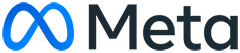</a>

<a href="https://colab.research.google.com/github/meta-llama/llama-cookbook/blob/main/getting-started/llama-tools/prompt-ops_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Getting Started with [prompt-ops](https://github.com/meta-llama/prompt-ops)

This notebook will guide you through the process of using [prompt-ops](https://github.com/meta-llama/prompt-ops) to optimize your prompts for Llama models. We'll cover:

1. Introduction to prompt-ops
2. Setting up your environment
3. Creating a sample project
4. Running prompt optimization
5. Analyzing the results
6. Advanced usage and customization

## 1. Introduction to prompt-ops

### What is prompt-ops?

prompt-ops is a Python package that **automatically optimizes prompts** for Llama models. It transforms prompts that work well with other LLMs into prompts that are optimized for Llama models, improving performance and reliability.

### How It Works

prompt-ops takes three key inputs:
1. Your existing system prompt
2. A dataset of query-response pairs for evaluation and optimization
3. A configuration file specifying model parameters and optimization details

It then applies optimization techniques to transform your prompt into one that works better with Llama models, and provides metrics to measure the improvement.

## 2. Setting up your environment

Let's start by installing the Prompt ops package and setting up our environment. We'll clone the repository and install it in editable mode to ensure we have the latest version, as the PyPI package is currently outdated.

In [ ]:
# Clone the repository and install in editable mode
!git clone https://github.com/meta-llama/prompt-ops.git
!cd prompt-ops && pip install -e .

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/rpdTracer-1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/HipMarker-1.0-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3.12 -m pip install --upgrade pip


## 2.1 Setting up your vllm server in another terminal

`!vllm serve Unsloth/Llama-3.3-70B-Instruct   --port 8001   --max-model-len 48000   --gpu-memory-utilization 0.85`

## 3. Creating a Sample Project

Prompt ops provides a convenient way to create a sample project with all the necessary files. Let's create a sample project to get started.

In [ ]:
# Create a sample project
!prompt-ops create my-notebook-project

[1/6] Creating project structure...
✓ Created project directory: my-notebook-project
✓ Created data directory
✓ Created prompts directory

[2/6] Generating configuration file...
✓ Created config.yaml

[3/6] Creating prompt template...
✓ Created prompt.txt

[4/6] Generating sample dataset...
✓ Created dataset.json with 200 examples

[5/6] Setting up environment...
✓ Created .env file

[6/6] Creating documentation...
✓ Created README.md

✨ Done! Project 'my-notebook-project' created successfully!

To get started:
1. cd my-notebook-project
2. Edit the .env file to add your OPENROUTER_API_KEY
   You can get an API key at: https://openrouter.ai/
3. Run: llama-prompt-ops migrate


### [Important] Update config.yaml for vLLM on AMD

```
system_prompt:
  file: prompts/prompt.txt
  inputs:
  - question
  outputs:
  - answer
dataset:
  path: data/dataset.json
  input_field:
  - fields
  - input
  golden_output_field: answer
model:
  task_model: hosted_vllm/Unsloth/Llama-3.3-70B-Instruct
  proposer_model: hosted_vllm/Unsloth/Llama-3.3-70B-Instruct
  api_base: http://localhost:8001/v1
  temperature: 0.0
  max_tokens: 4096
metric:
  class: llama_prompt_ops.core.metrics.FacilityMetric
  strict_json: false
  output_field: answer
optimization:
  strategy: llama


```

This command creates a directory called `my-notebook-project` with a sample configuration and dataset. Let's explore the files that were created:

In [35]:
!ls -la my-notebook-project

total 32
drwxr-xr-x  5 root root 4096 Oct 17 21:42 .
drwxr-xr-x 12 root root 4096 Oct 17 21:42 ..
-rw-r--r--  1 root root   48 Oct 17 21:42 .env
drwxr-xr-x  2 root root 4096 Oct 17 21:42 .ipynb_checkpoints
-rw-r--r--  1 root root  545 Oct 17 21:42 README.md
-rw-r--r--  1 root root  526 Oct 17 21:42 config.yaml
drwxr-xr-x  2 root root 4096 Oct 17 21:42 data
drwxr-xr-x  2 root root 4096 Oct 17 21:42 prompts


The sample project includes:
- `.env`: A file for your API key
- `README.md`: Documentation for the project
- `config.yaml`: Configuration file for prompt optimization
- `data/dataset.json`: Sample dataset for evaluation and optimization
- `prompts/prompt.txt`: Sample system prompt to optimize

Let's examine the configuration file:

In [36]:
!cat my-notebook-project/config.yaml

system_prompt:
  file: prompts/prompt.txt
  inputs:
  - question
  outputs:
  - answer
dataset:
  path: data/dataset.json
  input_field:
  - fields
  - input
  golden_output_field: answer
model:
  task_model: hosted_vllm/Unsloth/Llama-3.3-70B-Instruct
  proposer_model: hosted_vllm/Unsloth/Llama-3.3-70B-Instruct
  api_base: http://localhost:8001/v1
  temperature: 0.0
  max_tokens: 4096
metric:
  class: llama_prompt_ops.core.metrics.FacilityMetric
  strict_json: false
  output_field: answer
optimization:
  strategy: llama


The configuration file specifies:
- The system prompt to optimize
- The dataset to use for evaluation and optimization
- The model to use for optimization and evaluation
- The metric to use for evaluation
- The optimization strategy to use

Let's also look at the sample prompt and dataset:

In [37]:
!cat my-notebook-project/prompts/prompt.txt

You are a helpful assistant. Extract and return a json with the following keys and values:
- "urgency" as one of `high`, `medium`, `low`
- "sentiment" as one of `negative`, `neutral`, `positive`
- "categories" Create a dictionary with categories as keys and boolean values (True/False), where the value indicates whether the category is one of the best matching support category tags from: `emergency_repair_services`, `routine_maintenance_requests`, `quality_and_safety_concerns`, `specialized_cleaning_services`, `general_inquiries`, `sustainability_and_environmental_practices`, `training_and_support_requests`, `cleaning_services_scheduling`, `customer_feedback_and_complaints`, `facility_management_issues`
Your complete message should be a valid json string that can be read directly and only contain the keys mentioned in the list above. Never enclose it in ```json...```, no newlines, no unnessacary whitespaces.


In [38]:
!head -n 20 my-notebook-project/data/dataset.json

[
  {
    "fields": {
      "input": "Subject: Urgent Assistance Required for Specialized Cleaning Services\n\nDear ProCare Facility Solutions Support Team,\n\nI hope this message finds you well. My name is [Sender], and my family and I have been availing your services for our home for the past year. We have always appreciated the high standards and professionalism your team brings to maintaining our living environment.\n\nHowever, we are currently facing an urgent issue that requires immediate attention. We recently hosted a large gathering at our home, and despite our best efforts, there are several areas that now require specialized cleaning. Specifically, we need deep cleaning for our carpets and upholstery, as well as thorough window washing. The situation is quite pressing as we have more guests arriving soon, and we want to ensure our home is in pristine condition to welcome them.\n\nWe have tried some basic cleaning ourselves, but the results have not been satisfactory. Given t

## 4. Running Prompt Optimization

Now that we have our sample project set up, let's run the prompt optimization process. We'll use the `migrate` command, which takes a configuration file as input and outputs an optimized prompt.

In [ ]:
# Run prompt optimization
!cd my-notebook-project && prompt-ops migrate

Loaded environment variables from .env
Loaded configuration from config.yaml
2025-10-17 21:42:22,782 | INFO    |  Using model with DSPy: hosted_vllm/Unsloth/Llama-3.3-70B-Instruct
Using the same model for task and proposer: hosted_vllm/Unsloth/Llama-3.3-70B-Instruct
Using metric: FacilityMetric
Resolved relative dataset path to: /jupyter-tutorial/AIAC_134_199_204_96/my-notebook-project/data/dataset.json
Using dataset adapter: ConfigurableJSONAdapter
2025-10-17 21:42:22,783 - root - WARNING - Model '' does not appear to be a Llama model. This library is optimized for Llama models.
Auto-detected BasicOptimizationStrategy for model: 
2025-10-17 21:42:22,783 - root - WARNING - Model '<llama_prompt_ops.core.model.DSPyModelAdapter object at 0x75f3dd016b10>' does not appear to be a Llama model. This library is optimized for Llama models and may not work as expected.
2025-10-17 21:42:22,784 - root - INFO - Loaded 200 examples from /jupyter-tutorial/AIAC_134_199_204_96/my-notebook-project/data/

The optimization process will take a few minutes to complete. It involves:
1. Loading your system prompt and dataset
2. Analyzing the prompt structure and content
3. Applying optimization techniques specific to Llama models
4. Evaluating the optimized prompt against the original prompt
5. Saving the optimized prompt to the `results/` directory

Let's check the results directory to see the optimized prompt. If the optimizer successfully found a better prompt, it will be saved in the `results/` directory. You may need to run the optimization process again with different parameters or a larger dataset if the prompt is the same as the original.

In [ ]:
!ls -la my-notebook-project/results/

The optimized prompt is saved as a YAML file with a timestamp. Let's examine the contents of the optimized prompt:

In [9]:
import glob
import yaml

# Find the most recent result file
result_files = glob.glob('my-notebook-project/results/*.yaml')
if result_files:
    latest_result = max(result_files, key=os.path.getctime)
    print(f"Latest result file: {latest_result}")
    
    # Load and display the optimized prompt
    with open(latest_result, 'r') as f:
        result = yaml.safe_load(f)
        print("\nOptimized System Prompt:")
        print(result.get('system', 'No system prompt found'))
else:
    print("No result files found. Make sure the optimization process completed successfully.")

No result files found. Make sure the optimization process completed successfully.


## 5. Analyzing the Results

Let's compare the original prompt with the optimized prompt to understand the changes made during optimization.

In [10]:
# Load the original prompt
with open('my-notebook-project/prompts/prompt.txt', 'r') as f:
    original_prompt = f.read()

# Find the most recent result file again
result_files = glob.glob('my-notebook-project/results/*.yaml')
if result_files:
    latest_result = max(result_files, key=os.path.getctime)
    
    # Load the optimized prompt
    with open(latest_result, 'r') as f:
        result = yaml.safe_load(f)
        optimized_prompt = result.get('system', 'No system prompt found')
    
    # Print the comparison
    print("Original Prompt:")
    print("-" * 80)
    print(original_prompt)
    print("\n" + "-" * 80)
    print("\nOptimized Prompt:")
    print("-" * 80)
    print(optimized_prompt)
    print("-" * 80)
else:
    print("No result files found. Make sure the optimization process completed successfully.")

No result files found. Make sure the optimization process completed successfully.


### Key Differences in the Optimized Prompt

The optimized prompt typically includes several improvements:

1. **Better Structure**: Llama models respond better to clear, structured instructions
2. **Llama-Specific Formatting**: Formatting that works better with Llama's training patterns
3. **Few-Shot Examples**: Examples that help the model understand the expected output format
4. **Clear Output Expectations**: More explicit instructions about what the output should look like

These changes can significantly improve the model's performance on your specific task.

## 6. Advanced Usage and Customization

### Using Your Own Data

To use your own data with Prompt ops, you'll need to:

1. Prepare your dataset in JSON format
2. Create a system prompt file
3. Create a configuration file

Check out the comprehensive guide [here](https://github.com/meta-llama/prompt-ops/tree/main/docs) to learn more.

Now, let's see how to create a custom configuration file:



In [11]:
%%writefile custom_config.yaml
system_prompt:
  file: "path/to/your/prompt.txt"
  inputs: ["question"]
  outputs: ["answer"]

# Dataset configuration
dataset:
  path: "path/to/your/dataset.json"
  input_field: "question"  # or ["fields", "input"] for nested fields
  golden_output_field: "answer"

# Model configuration
model:
  task_model: "openrouter/meta-llama/llama-3.3-70b-instruct"
  proposer_model: "openrouter/meta-llama/llama-3.3-70b-instruct"

# Metric configuration
metric:
  class: "prompt_ops.core.metrics.StandardJSONMetric"
  strict_json: false
  output_field: "answer"

# Optimization settings
optimization:
  strategy: "llama"

Writing custom_config.yaml


### Using Different Metrics

Prompt ops supports different metrics for evaluating prompt performance. The default is `StandardJSONMetric`, but you can use other metrics like `FacilityMetric` for specific use cases.

Here's an example of using the `FacilityMetric` for the facility support analyzer use case:

In [12]:
%%writefile facility_config.yaml
system_prompt:
  file: "prompts/facility_prompt.txt"
  inputs: ["question"]
  outputs: ["answer"]

# Dataset configuration
dataset:
  path: "data/facility_dataset.json"
  input_field: ["fields", "input"]
  golden_output_field: "answer"

# Model configuration
model:
  name: "openrouter/meta-llama/llama-3.3-70b-instruct"
  task_model: "openrouter/meta-llama/llama-3.3-70b-instruct"
  proposer_model: "openrouter/meta-llama/llama-3.3-70b-instruct"

# Metric configuration
metric:
  class: "prompt_ops.core.metrics.FacilityMetric"
  strict_json: false
  output_field: "answer"

# Optimization settings
optimization:
  strategy: "llama"

Writing facility_config.yaml


### Using Different Models

Prompt ops supports different models through various inference providers. You can use OpenRouter, vLLM, or NVIDIA NIMs depending on your infrastructure needs.

Here's an example of using a different model through OpenRouter:

In [13]:
%%writefile different_model_config.yaml
system_prompt:
  file: "prompts/prompt.txt"
  inputs: ["question"]
  outputs: ["answer"]

# Dataset configuration
dataset:
  path: "data/dataset.json"
  input_field: "question"
  golden_output_field: "answer"

# Model configuration
model:
  name: "openrouter/meta-llama/llama-3.1-8b-instruct"
  task_model: "openrouter/meta-llama/llama-3.1-8b-instruct"
  proposer_model: "openrouter/meta-llama/llama-3.1-8b-instruct"

# Metric configuration
metric:
  class: "prompt_ops.core.metrics.StandardJSONMetric"
  strict_json: false
  output_field: "answer"

# Optimization settings
optimization:
  strategy: "llama"

Writing different_model_config.yaml


## Conclusion

In this notebook, we've covered:

1. Introduction to Prompt ops and its benefits
2. Creating a sample project
3. Setting up your environment and API key
4. Running prompt optimization
5. Analyzing the results
6. Advanced usage and customization options

Prompt ops provides a powerful way to optimize your prompts for Llama models, improving performance and reliability. By following the steps in this notebook, you can start optimizing your own prompts and building more effective LLM applications.

For more information, check out the [prompt-ops documentation](https://github.com/meta-llama/prompt-ops/tree/main/docs) and explore the example use cases in the repository.